<a href="https://colab.research.google.com/github/Enrique720/Proyecto-BigData/blob/main/Proyecto_Pillow_Angel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocesamiento

In [9]:
import os
import shutil
from PIL import Image
from numpy import asarray, remainder
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
work_dir = '/content/drive/MyDrive/01BigData/BigDataProject'
src_dataset_dir = 'RAW_FISH_DATASET'
aug_dataset_dir = 'AUGMENTED DATASET/PILLOW'
list_species = ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel',
                'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

In [4]:
def clean_create_workspace():
    print("*** Clean_Create_Workspace ***")
    print("-- Delete previous directories --")
    for directory in list_species:
        try:
            dir_path = os.path.join(work_dir, aug_dataset_dir, directory)
            shutil.rmtree(dir_path)
            print("Directory successfully deleted:", dir_path)
        except OSError as e:
            print("OS msg:", e.strerror)

    print("-- Create directories --")
    for directory in list_species:
        dir_path = os.path.join(work_dir, aug_dataset_dir, directory)
        os.mkdir(dir_path)
        print("Directory successfully created:", dir_path)

In [5]:
# Helper function: usada para numerar los archivos aumentados
# Input: un numero tipo int
# Return: un numero tipo string
def convert_num_string(num):
    len_final_str = 5
    num_str = str(num)
    remainder = len_final_str - len(num_str)
    ans = remainder * '0' + num_str  # Eg.  ans = '00012'
    return ans

In [30]:
# Funcion que realiza augmentation de data: Resize(590, 445)px, rotation, flip
# Input: recibe la lista de especies 'list_spacies' y un factor 'n'
# Output: realiza un aumento de fotos de tamaño = #fotos_raw_data * n
def augmentation_data(list_species, n):
  print("*** Augmentation_Data ***")
  for specie in list_species:
    src_dir = os.path.join(work_dir, src_dataset_dir, specie)
    dest_dataset_dir = os.path.join(work_dir, aug_dataset_dir, specie)
    num_file = 1
    for filename in os.listdir(src_dir):
      # load image
      pic_path = src_dir + "/" + filename
      print("\nProcessing picture:", pic_path)
      image = Image.open(pic_path)
      # Resize Image
      #print('> Original size: %s %s' % (image.size))
      image.thumbnail((590, 445))
      #print('> Final size: %s %s' % (image.size))
      # Por cada iteracion genera 2 transformaciones del archivo
      num_iter = n + 1 if (n % 2 > 0) else n
      num_iter = int(num_iter / 2)
      for i in range(num_iter):
        # Transformation #1: Flip image
        img_transformed = image.transpose(Image.FLIP_LEFT_RIGHT)
        # Save flipped image
        format_file = filename.split('.')[1]
        num_pic_file = convert_num_string(num_file)
        dest_path_file = dest_dataset_dir + "/" + num_pic_file + "." + format_file
        print("save file: ", dest_path_file)
        img_transformed.save(dest_path_file)
        # Transformation #2: rotation
        img_transformed = img_transformed.rotate(25 * (i + 1))
        # Save rotated image
        num_file += 1
        num_pic_file = convert_num_string(num_file)
        dest_path_file = dest_dataset_dir + "/" + num_pic_file + "." + format_file
        img_transformed.save(dest_path_file)
        print("save file: ", dest_path_file)
        num_file += 1

## Main Workflow Execution

In [28]:
# Clean destination directory
clean_create_workspace()

*** Clean_Create_Workspace ***
-- Delete previous directories --
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Black Sea Sprat
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Gilt Head Bream
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Horse Mackerel
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Red Mullet
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Red Sea Bream
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Sea Bass
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Shrimp
Directory successfully deleted: /content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW/Striped

In [ ]:
# Execute Augmentation
list_species_test = ['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
# Duplica el tamaño del dataset original para la lista de especies
n = 10
start = time.time()
augmentation_data(list_species_test, n)  
end = time.time()
print("Elapsed time:", end - start, "(segs)")

## Procesamiento

In [15]:
from pathlib import Path
import numpy as np 
import pandas as pd

In [31]:
# Load Data
dataset_path = Path(r'/content/drive/MyDrive/01BigData/BigDataProject/AUGMENTED DATASET/PILLOW')
file_path = list(dataset_path.glob(r'**/*.*'))

# Create labels from source folder
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [32]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
1,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
2,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
3,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat
4,/content/drive/MyDrive/01BigData/BigDataProjec...,Black Sea Sprat


In [33]:
# Show class images
df.label.value_counts()

Horse Mackerel        500
Black Sea Sprat       500
Red Mullet            500
Trout                 500
Shrimp                500
Striped Red Mullet    500
Sea Bass              500
Red Sea Bream         500
Gilt Head Bream       500
Name: label, dtype: int64

In [37]:
# Create train, test, validation dataset
from sklearn.model_selection import train_test_split

In [38]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [39]:
print("Shape training data", x_train.shape)
print("Shape test data", x_test.shape)
print("Shape validation data", x_val.shape)

Shape training data (2520, 2)
Shape test data (1350, 2)
Shape validation data (630, 2)


In [43]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [44]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 2520 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 630 validated image filenames belonging to 9 classes.


In [45]:
# Model definition
input_shape = (200, 200, 3)

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 32)      

In [48]:
from tensorflow.keras.optimizers import Adam

In [50]:
# Training model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
start = time.time()
history = model.fit(train, validation_data=val, epochs=10, callbacks=callback)
end = time.time()
print("Elapsed time:", end - start, "(segs)")

Epoch 1/10
79/79 [==============================] - 312s 4s/step - loss: 2.1639 - accuracy: 0.1369 - val_loss: 2.0117 - val_accuracy: 0.1921
Epoch 2/10
79/79 [==============================] - 309s 4s/step - loss: 1.9475 - accuracy: 0.2254 - val_loss: 1.7733 - val_accuracy: 0.2667
Epoch 3/10
79/79 [==============================] - 313s 4s/step - loss: 1.7127 - accuracy: 0.2968 - val_loss: 1.6442 - val_accuracy: 0.3571
Epoch 4/10
79/79 [==============================] - 304s 4s/step - loss: 1.5698 - accuracy: 0.3627 - val_loss: 1.5722 - val_accuracy: 0.3730
Epoch 5/10
79/79 [==============================] - 303s 4s/step - loss: 1.3614 - accuracy: 0.4484 - val_loss: 1.2236 - val_accuracy: 0.5222
Epoch 6/10
79/79 [==============================] - 302s 4s/step - loss: 1.2149 - accuracy: 0.5123 - val_loss: 1.0612 - val_accuracy: 0.5635
Epoch 7/10
79/79 [==============================] - 307s 4s/step - loss: 1.2199 - accuracy: 0.5099 - val_loss: 1.0249 - val_accuracy: 0.5905
Epoch 8/10
79

In [51]:
# Save model
model.save('/content/drive/MyDrive/01BigData/BigDataProject/model-pillow-500.h5')

In [52]:
# Verify model performance 
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

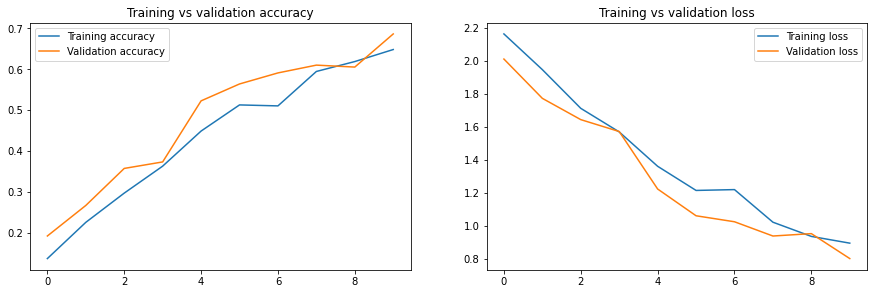

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()